In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import optuna
import random
import joblib

results_dir = '../results/variables=[0,2]'
images_dir = '../images/variables=[0,2]'
data_dir = '../data/syntheticdata/variables=[0,2]'

In [2]:
import torch
from torch import nn
import torch.optim as optim
from train_pipeline import ModelTrainingPipeline

seed = 1729

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModelTrainingPipeline.set_seed(seed)

x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
from torch.nn.utils.rnn import pad_sequence

def create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = [], [], []  # X1: data, X2: indexes of the motifs, y: distance to the next motif
    
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period_end = window_end_idx + forecast_period

        # If there are no more matches after the window, break
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        # Motif indexes in window, relative to the start of the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period_end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  # No match in the forecast period but exists in the future

        # Get the data window and transpose to (lookback_period, num_features)
        data_window = data[variable_indexes, idx:window_end_idx].T

        # Calculate `y`
        data_y = -1
        if next_match_in_forecast_period != -1:
            # Index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        # Append to lists
        X1.append(torch.tensor(data_window, dtype=torch.float32))  # Now with shape (lookback_period, num_features)
        X2.append(torch.tensor(motif_indexes_in_window, dtype=torch.long)) 
        y.append(data_y) 

    # Pad X2 sequences to have the same length
    X2_padded = pad_sequence(X2, batch_first=True, padding_value=-1) # Final shape: (num_samples, max_num_motifs)
    
    # Convert lists to torch tensors
    X1 = torch.stack(X1)  # Final shape: (num_samples, lookback_period, num_features)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    return X1, X2_padded, y


In [4]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = np.arange(k)
variables_pattern = [0,2]

dataset_path = os.path.join(data_dir, "n={}_k={}_p={}_min_step={}_max_step={}_variables={}.csv".format(n, k, p, 5, 45, variables_pattern))
motif_indexes_path = os.path.join(data_dir, "motif_indexes_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0     5    12 ... 99948 99965 99984]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


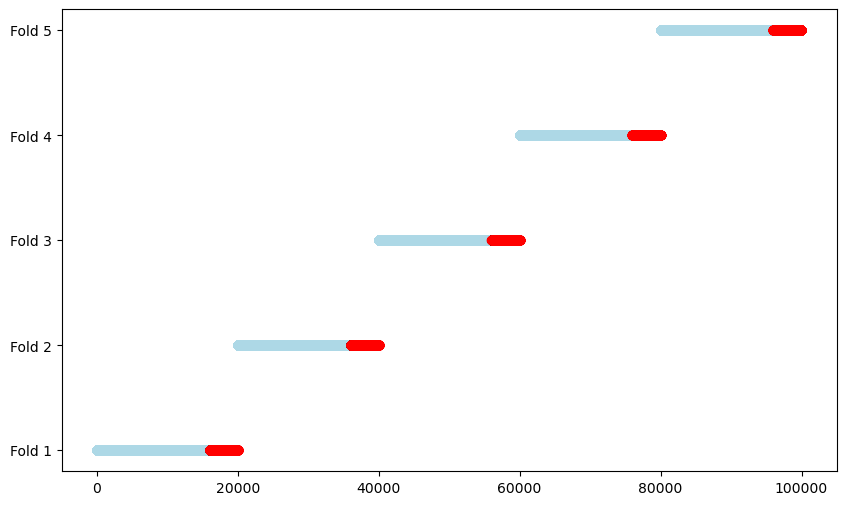

In [5]:
from timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [6]:
lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19977, 100, 3])
X2 shape: torch.Size([19977, 8])
y shape: torch.Size([19977, 1])


In [7]:
def run_optuna_study(objective_func, model_class, model_type, seed, X1, y, results_folder: str, n_trials: int = 100, num_epochs=500, X2=None, suggestion_dict=None, model_params_keys=None):
    if suggestion_dict is None:
        raise ValueError("Please provide a dictionary of hyperparameter suggestions.")

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    file_name = os.path.join(results_folder, "study.pkl")
    
    def objective(trial):
        # Extract basic hyperparameters from the suggestion dictionary
        hyperparameters = {
            param_name: getattr(trial, f"suggest_{param_details['type']}")
            (
                param_name,
                *param_details['args'],  # Pass positional arguments
                **param_details.get('kwargs', {})  # Pass optional keyword arguments
            )
            for param_name, param_details in suggestion_dict.items()
        }
        
        if "num_layers" in hyperparameters:
            num_layers = hyperparameters["num_layers"]
            hidden_sizes = [
                trial.suggest_categorical(f"hidden_size_layer_{i}", [16, 32, 64, 128, 256] )
                for i in range(num_layers)
            ]
            hyperparameters["hidden_sizes"] = hidden_sizes
        
        criterion = torch.nn.MSELoss()  # Define the criterion here
        trial_val_loss, _, _ = objective_func(trial, seed, results_folder, model_class, model_type, X1, y, X2, criterion, num_epochs, hyperparameters, model_params_keys)  # Pass hyperparameters

        return trial_val_loss

    # Let Optuna manage trials and pass them to the objective function
    study.optimize(objective, n_trials=n_trials)
    joblib.dump(study, file_name)

    # Save and log the study results
    study_df = study.trials_dataframe()
    study_df.to_csv(os.path.join(results_folder, "study_results.csv"), index=False)

    print("Best hyperparameters:", study.best_params)

def print_study_results(study):
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:", study.best_trial.number)
    print("Best hyperparameters:", study.best_params)
    print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
    print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
    print("Test Losses", study.best_trial.user_attrs["test_losses"])
    print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
    print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
    print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

def plot_best_model_results(study_df, save_path=None):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

    best_fold_train_losses = []
    best_fold_val_losses = []

    for i in range(5):
        # Extract losses for the best trial for the current fold
        best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
        best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])

        # Plot train and validation losses in the current subplot
        axes[i].plot(best_fold_train_losses[i], label="Train Loss")
        axes[i].plot(best_fold_val_losses[i], label="Validation Loss")

        # Customize the subplot
        axes[i].set_title(f"Fold {i + 1}")
        axes[i].set_xlabel("Epoch")
        if i == 0:  # Only set ylabel for the first subplot
            axes[i].set_ylabel("Loss")
        axes[i].legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


[I 2024-12-04 19:40:08,370] A new study created in memory with name: no-name-1f63d6a3-26d3-4578-af70-b325ed529873


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 48
Training completed all epochs. Best epoch was 49


[I 2024-12-04 19:41:09,857] Trial 0 finished with value: 113.33224334716797 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 5, 'batch_size': 64, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 128, 'hidden_size_layer_4': 16}. Best is trial 0 with value: 113.33224334716797.


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 34
Training completed all epochs. Best epoch was 32
Training completed all epochs. Best epoch was 40
Training completed all epochs. Best epoch was 41


[I 2024-12-04 19:41:36,227] Trial 1 finished with value: 98.07677459716797 and parameters: {'learning_rate': 0.0005201806287602701, 'num_layers': 2, 'batch_size': 128, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}. Best is trial 1 with value: 98.07677459716797.


Training completed all epochs. Best epoch was 49
Best hyperparameters: {'learning_rate': 0.0005201806287602701, 'num_layers': 2, 'batch_size': 128, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}
Number of finished trials:  2
Best trial: 1
Best hyperparameters: {'learning_rate': 0.0005201806287602701, 'num_layers': 2, 'batch_size': 128, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}
Validation Losses [99.05364227294922, 97.90726470947266, 101.92530059814453, 96.66735076904297, 94.83031463623047]
Mean validation loss: 98.07677459716797
Test Losses [98.51676940917969, 103.19691467285156, 96.61604309082031, 103.52145385742188, 95.6452407836914]
Mean test loss: 99.49928436279296
Mean test MAE: 8.070760250091553
Mean test RMSE: 9.973576545715332


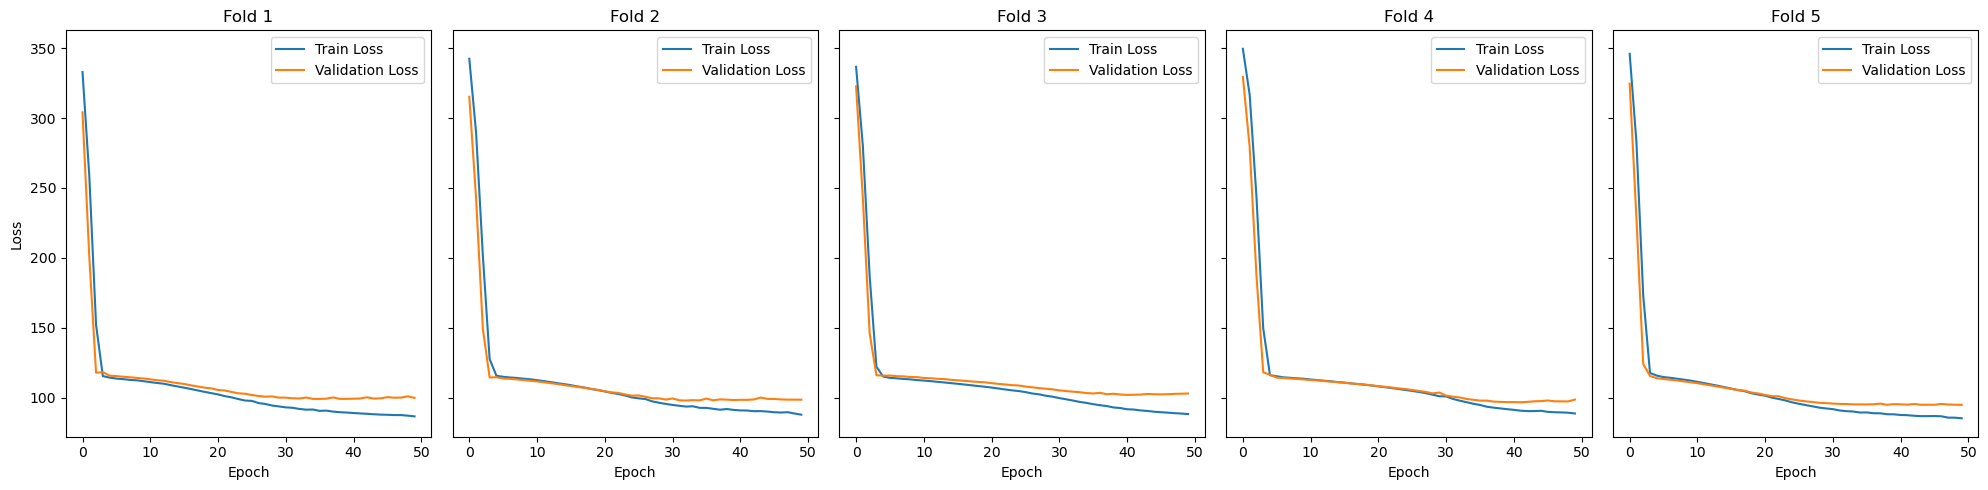

In [8]:
from models.ffnn_pytorch import FFNNX1
from train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 2
num_epochs = 50
model_type = "FFNN"
model_name = "FFNNX1"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4, 5]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes"]


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)

run_optuna_study(pipeline.run_cross_val, FFNNX1, model_type, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=None, suggestion_dict=suggestion_dict, model_params_keys=model_params_keys)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


In [9]:
from models.ffnn_pytorch import FFNNX1_X2Masking
from train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 2
num_epochs = 50
model_type = "FFNN"
model_name = "FFNNX1_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4, 5]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes"]

#X1 shape is (num_samples, lookback_period)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)

run_optuna_study(pipeline.run_cross_val, FFNNX1_Masking, model_type, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=masking_X1, suggestion_dict=suggestion_dict, model_params_keys=model_params_keys)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


NameError: name 'FFNNX1_Masking' is not defined